# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)  Project 4: Web Scraping Job Postings

## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

---

## Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to answer the two questions described above.




### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

---

## Requirements

1. Scrape and prepare your own data.

2. **Create and compare at least two models for each section**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).
   - Section 1: Job Salary Trends
   - Section 2: Job Category Factors

3. Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists. 
   - Make sure to clearly describe and label each section.
   - Comment on your code so that others could, in theory, replicate your work.

4. A brief writeup in an executive summary, written for a non-technical audience.
   - Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.



## Suggestions for Getting Started

1. Collect data from [Indeed.com](www.indeed.com) (or another aggregator) on data-related jobs to use in predicting salary trends for your analysis.
  - Select and parse data from *at least 1000 postings* for jobs, potentially from multiple location searches.
2. Find out what factors most directly impact salaries (e.g. title, location, department, etc).
  - Test, validate, and describe your models. What factors predict salary category? How do your models perform?
3. Discover which features have the greatest importance when determining a low vs. high paying job.
  - Your Boss is interested in what overall features hold the greatest significance.
  - HR is interested in which SKILLS and KEY WORDS hold the greatest significance.   
4. Author an executive summary that details the highlights of your analysis for a non-technical audience.
5. If tackling the bonus question, try framing the salary problem as a classification problem detecting low vs. high salary positions.

---

## Useful Resources

- Scraping is one of the most fun, useful and interesting skills out there. Don’t lose out by copying someone else's code!
- [Here is some advice on how to write for a non-technical audience](http://programmers.stackexchange.com/questions/11523/explaining-technical-things-to-non-technical-people)
- [Documentation for BeautifulSoup can be found here](http://www.crummy.com/software/BeautifulSoup/).

---

### Project Feedback + Evaluation

For all projects, students will be evaluated on a simple 3 point scale (0, 1, or 2). Instructors will use this rubric when scoring student performance on each of the core project **requirements:** 

Score | Expectations
----- | ------------
**0** | _Does not meet expectations. Try again._
**1** | _Meets expectations. Good job._
**2** | _Surpasses expectations. Brilliant!_

[For more information on how we grade our DSI projects, see our project grading walkthrough.](https://git.generalassemb.ly/dsi-projects/readme/blob/master/README.md)


# Webscraping Careers Future

In [3]:
from bs4 import BeautifulSoup
import requests
import re
from fake_useragent import UserAgent

from selenium import webdriver
from time import sleep
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from xlsxwriter import Workbook
import os

import requests
import shutil
import math

### We shall search jobs by term : 'Analytics' 1000+ search results, which includes Data jobs 

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.


In [318]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

In [319]:
analytics = pd.read_csv('analyticsfinal.csv')

In [320]:
analytics.shape

(1040, 9)

In [321]:
analytics.dtypes

Title             object
Company           object
Location          object
Range             object
Monthly/Annual    object
Seniority         object
JD                object
Req               object
Industry          object
dtype: object

In [322]:
analytics.columns

Index(['Title', 'Company', 'Location', 'Range', 'Monthly/Annual', 'Seniority',
       'JD', 'Req', 'Industry'],
      dtype='object')

In [323]:
# drop indices that are 'undisclosed' salary
analytics.drop(index=analytics[analytics.Range == 'undisclosed'].index, inplace=True)

In [324]:
analytics.reset_index(drop=True,inplace=True)

In [325]:
analytics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 9 columns):
Title             921 non-null object
Company           921 non-null object
Location          921 non-null object
Range             921 non-null object
Monthly/Annual    921 non-null object
Seniority         921 non-null object
JD                921 non-null object
Req               921 non-null object
Industry          921 non-null object
dtypes: object(9)
memory usage: 64.8+ KB


### Data Clean up and creating the target variable

In [326]:
#cleanup the salary range column
analytics.Range = analytics.Range.str.replace('$','')
analytics.Range = analytics.Range.str.replace(',','')
analytics.Range = analytics.Range.str.split('to')

In [327]:
analytics['min_salary'] = analytics.Range.map(lambda x:x[0]).astype(float)

In [328]:
analytics['max_salary'] = analytics.Range.map(lambda x:x[1]).astype(float)

In [329]:
analytics['expected_salary'] = (analytics['min_salary'] + analytics['max_salary'])/2

In [330]:
analytics['Monthly_expected_salary'] = analytics[analytics['Monthly/Annual'] == 'Annually']['expected_salary'].apply(lambda x:(x//12))

In [331]:
# add new feature Expected monthly salary  
analytics['Monthly_expected_salary'].fillna(analytics['expected_salary'],inplace=True)

In [332]:
analytics.columns

Index(['Title', 'Company', 'Location', 'Range', 'Monthly/Annual', 'Seniority',
       'JD', 'Req', 'Industry', 'min_salary', 'max_salary', 'expected_salary',
       'Monthly_expected_salary'],
      dtype='object')

In [333]:
# Drop those that we dont need
analytics.drop (columns=['Range','Monthly/Annual','expected_salary'],inplace=True)

In [334]:
# Not surprising that 
analytics.Industry.value_counts().head()

Information Technology          325
Banking and Finance              82
Sciences / Laboratory / R&D      76
Marketing / Public Relations     40
Consulting                       38
Name: Industry, dtype: int64

In [335]:
# clean up the JD and req column
analytics.JD = analytics.JD.str.replace('\r\n',' ')
analytics.Req = analytics.Req.str.replace('\r\n',' ')

In [336]:
# looking at the salary ranges
print('Highest monthly salary',analytics.Monthly_expected_salary.max()) # I gotta get me one of these jobs?
print ('Lowest monthly salary',analytics.Monthly_expected_salary.min())

Highest monthly salary 95000.0
Lowest monthly salary 625.0


In [337]:
# Not sure if this can tell us anything
# Look like first 'seniority' call is the most accurate
# employers might just be spamming tags to up their chances of being found.
analytics.Seniority.value_counts() 

Professional                                                        269
Manager                                                             151
Executive                                                           147
Senior Executive                                                     80
Middle Management                                                    56
Non-executive                                                        38
Senior Management                                                    34
Junior Executive                                                     22
Fresh/entry level                                                    18
Middle Management, Manager                                           16
Manager, Professional                                                12
Executive, Senior Executive                                           9
Manager, Senior Executive                                             8
undisclosed                                                     

In [338]:
#let's just take the first one
analytics['Level'] = analytics.Seniority.apply(lambda x:x.split(',')[0])

In [339]:
analytics.Level.unique()

array(['Manager', 'Middle Management', 'Professional', 'Senior Executive',
       'Executive', 'Fresh/entry level', 'Senior Management',
       'Non-executive', 'Junior Executive', 'undisclosed'], dtype=object)

In [340]:
analytics['Level_num'] = analytics['Level'].replace({'Senior Management':8,
                            'Middle Management':7,
                            'Manager':6,
                            'Professional':5,
                            'Senior Executive':4,
                            'Executive':3,
                            'Junior Executive':2,
                            'Non-executive':1,
                            'Fresh/entry level':0,
                           'undisclosed':'undisclosed'})

In [341]:
analytics.drop('Seniority',axis=1,inplace=True)

In [342]:
analytics.Level_num.value_counts()

5              278
6              173
3              166
4               80
7               78
8               46
1               38
0               31
2               24
undisclosed      7
Name: Level_num, dtype: int64

In [343]:
#drop rows without seniority
analytics.drop(index=analytics[analytics.Level == 'undisclosed'].index, inplace=True)

In [254]:
analytics.Req

0      Requirements About you To be successfully cons...
1      Requirements PhD/Masters/Bachelors in Computer...
2      Requirements Experience in big data and machin...
3      Requirements 7+ years professional application...
4      Requirements Your role:  Design and developmen...
5      Requirements University degree with focus on q...
6      Requirements Minimum of 5 years of experience ...
7      Requirements The successful candidate should p...
8      Requirements The successful candidate should p...
9      Requirements The Marketing Operations Speciali...
10     Requirements SENIOR RECRUITER, APAC - Base in ...
11     Requirements Ideal candidates for this role: T...
12     Requirements Proficient in MS Office skills (M...
13     Requirements a) MS / BS Computer Science / Eng...
14     Requirements BSc/Ba in Banking and Finance or ...
15     Requirements Understand key concepts, techniqu...
16     Requirements - BSc/BA in Computer Science, Eng...
17     Requirements Understand 

In [344]:
# same for the industry columns?
# there are 121 with second industry out of 921 . Keep the first one
len([list[1] for list in analytics.Industry.apply(lambda x:x.split(',')) if len(list) >=2])

118

In [345]:
analytics['Industry'] = analytics.Industry.apply(lambda x:x.split(',')[0])

In [368]:
analytics['Experience'] = analytics.Req.str.findall(r"\d\syears\sof\sexperience")

In [369]:
analytics['Experience'] = analytics['Experience'].astype(str).replace('[]',np.nan).str.findall(r'\d')

In [378]:
analytics[analytics['Experience'].notnull()]['Experience']

6            [5]
7         [5, 4]
8         [5, 4]
9            [3]
21           [6]
26           [3]
32           [5]
35           [5]
41           [2]
43           [3]
44           [3]
52           [3]
61           [3]
63           [4]
66        [5, 3]
75           [3]
81           [8]
93           [0]
95        [4, 4]
117          [5]
119    [3, 3, 1]
120          [3]
121    [3, 3, 1]
127          [0]
131          [3]
135          [4]
139       [7, 5]
141          [5]
144    [3, 3, 1]
145          [3]
         ...    
882          [4]
883          [4]
884          [3]
885          [6]
886          [4]
887          [4]
888          [3]
889          [5]
890          [6]
891          [5]
892          [5]
893          [4]
894          [4]
895          [3]
896          [6]
897          [5]
898          [4]
899          [4]
900          [3]
901          [6]
902          [6]
903          [5]
904          [4]
905          [4]
906          [3]
907          [6]
908          [4]
909          [

### EDA

In [105]:
analytics['Req'] = analytics.Req.apply(lambda x:x.lower())

In [317]:
# about half of the jobs explicitly state they require at least a degree
print('Requires Degree:' , len(analytics[analytics.Req.str.contains('bsc|degree|bachelor')]))
print('Requires Masters:' , len(analytics[analytics.Req.str.contains('master')]))
print('Requires PhD:' , len(analytics[analytics.Req.str.contains('phd')]))

Requires Degree: 273
Requires Masters: 10
Requires PhD: 0


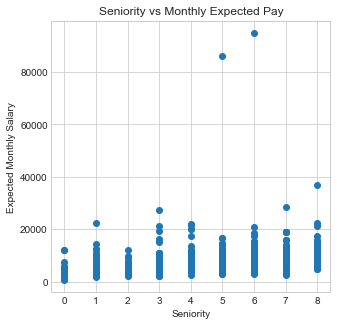

In [107]:
#distribution of seniority vs monthly expected pay 
sns.set_style("whitegrid")
plt.figure(figsize=(5,5))
plt.scatter(analytics['Level_num'],analytics['Monthly_expected_salary'])
plt.title ('Seniority vs Monthly Expected Pay')
plt.xlabel('Seniority')
plt.ylabel('Expected Monthly Salary')
plt.show()

/Users/zachlim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


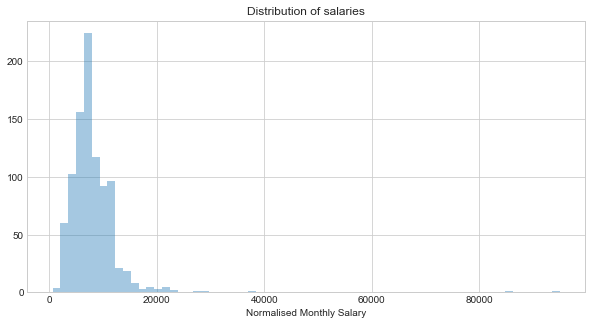

In [88]:
# Salaries are very right skewed. Highest wage earners make multiples of the mode ,median and mean
plt.figure (figsize = (10,5))
sns.distplot(analytics['Monthly_expected_salary'],norm_hist=False,kde=False,bins = 65)
plt.title ('Distribution of salaries')
plt.xlabel ('Normalised Monthly Salary')
plt.show()

In [36]:
analytics.sample(10)

,Title,Company,Location,JD,Req,Industry,min_salary,max_salary,Monthly_expected_salary,Level
7,Senior Manager / Manager / Senior Consultant,DELOITTE & TOUCHE ENTERPRISE RISK SERVICES PTE...,"OUE DOWNTOWN, 6 SHENTON WAY 068809",You will work with clients to assess and impro...,requirements the successful candidate should p...,Risk Management,4500.0,10000.0,7250.0,Manager
12,Assistant Planner,CYBERSPROUT PTE. LTD.,"GOLDEN AGRI PLAZA, 108 PASIR PANJANG ROAD 118535","THE ROLE Responsible for the accurate, efficie...",requirements proficient in ms office skills (m...,Information Technology,3600.0,5000.0,4300.0,Executive
317,Associate Engineer (Fullstack),NTUC ENTERPRISE NEXUS CO-OPERATIVE LIMITED,undisclosed,"Today, we have embarked on a transformation an...",requirements requirements · 3 years ...,Information Technology,5000.0,8000.0,6500.0,Professional
834,Risk Assurance Senior Associate (Data analytic...,ERNST & YOUNG ADVISORY PTE. LTD.,1 RAFFLES QUAY 048583,Our clients rely on us in providing them with ...,requirements your key responsibilities as part...,Consulting,3000.0,6000.0,4500.0,Fresh/entry level
245,SAP BI HANA Consultant,ICON CONSULTING-GROUP PTE. LTD.,undisclosed,We are looking for an experienced SAP BI lead ...,requirements bachelor’s degree in computer sci...,Information Technology,8000.0,12000.0,10000.0,Professional
196,Data Analyst,COMPANY UNDISCLOSED,undisclosed,About Our Client Our client is a market leader...,requirements the successful applicant bachelor...,Information Technology,5000.0,7000.0,6000.0,Professional
161,"Data Analytics - Excel Macro, Tableau, SQL",OPTIMUM SOLUTIONS (SINGAPORE) PTE LTD,"PLAZA 8 @ CBP, 1 CHANGI BUSINESS PARK CRESCENT...",Optimum Solutions (Company Registration Number...,requirements essential technical skill :- min ...,Information Technology,4500.0,8500.0,6500.0,Senior Management
666,SEO Marketing Manager,CYBERSPROUT PTE. LTD.,"GOLDEN AGRI PLAZA, 108 PASIR PANJANG ROAD 118535","Create, implement, analyse SEO strategies for ...",requirements 2+ years’ experience in search en...,Marketing / Public Relations,4500.0,6000.0,5250.0,Manager
858,"Officer, Business Operations, Chief Technology...",ALEXANDER MANN BPO SOLUTIONS (SINGAPORE) PTE. ...,"SGX CENTRE I, 2 SHENTON WAY 068804",About Bank of America Merrill Lynch: Our purpo...,requirements key requirements minimum 2 years ...,Banking and Finance,5000.0,7000.0,6000.0,Professional
680,Business Intelligence Lead,KELLY SERVICES (SINGAPORE) PTE. LTD.,"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Primary responsibility for QLIK Reports/Dashbo...,requirements requirements: knowledge of script...,Information Technology,8000.0,12000.0,10000.0,Non-executive


### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.


In [ ]:
# we can create a target variable that identifies 

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [ ]:
corpus = []
for i in range(0,920):
    req = re.sub('[^a-zA-Z]',' ',analytics['Req'][i])
    req = req.split()
    ps = PorterStemmer()
    req = [word for word in req if not word in set(stopwords.words('english'))]
    req = ' '.join(req)
    corpus.append(req)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer=text_process)
X= cv.fit_transform(corpus)
y = analytics.iloc[:,-2]

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit_transform(corpus)

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

#### BONUS

5. Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.

6. Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

---